# importation des données

In [ ]:
!pip install pyarrow
!pip install xgboost
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyarrow.parquet as pq
import pandas as pd # bibliothèque de manipulation de données tabulaires
import numpy as np #  bibliothèque de manipulation des tableaux de données multidimensionnels
import matplotlib.pyplot as plt # bibliothèque de visualisation de données
import seaborn as sns #  bibliothèque de visualisation de données : graphiques statistiques
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import *
%matplotlib inline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsRegressor

IMPORTATION DES DONNEES

In [ ]:
# Chemin du fichier Parquet
#chemin_fichier = "/content/yellow_tripdata_2023-03.parquet"
chemin_fichier = "yellow_tripdata_2023-03.parquet"

# Lecture du fichier Parquet
table = pq.read_table(chemin_fichier)

# Conversion de la table en DataFrame pandas
dataframe = table.to_pandas()

chemin_fichier = "/content/export.csv"

# Importer le fichier CSV dans un DataFrame
df_weather = pd.read_csv(chemin_fichier, delimiter=';')


In [ ]:
dataframe.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


In [ ]:
dataframe.shape

(3403766, 19)

graphique avant nettoyage

# nettoyage des données

NETTOYAGE DES DONNEES
- suppression variables calculées dans le tarif

In [ ]:
dataframe.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
RatecodeID               87619
store_and_fwd_flag       87619
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     87619
Airport_fee              87619
dtype: int64

variable à prédire : total_amount
pour la prédire : ne pas prendre en compte les autres variables monétaires
suppression de :
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- improvement_surcharge
- congestion_surcharge
- airport_fee

In [ ]:
df=dataframe.drop(['fare_amount', 'extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','Airport_fee','RatecodeID'], axis=1)

In [ ]:
df=df.drop(['VendorID', 'store_and_fwd_flag'], axis=1)

In [ ]:
df.isnull().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

suppression des lignes vides pour maximiser la modélisation

In [ ]:
moy=int(df['passenger_count'].mean())

In [ ]:
df['passenger_count'] = df['passenger_count'].replace(np.nan, moy) #remplacement par la moyenne du nbre de passager

In [ ]:
#df=df.dropna(subset=['passenger_count'],axis=0) #suppression des lignes

In [ ]:
df.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

CREATION DE VARIABLES
Détails des dates  :
- mois
- jour
- année
- heures
- minutes
- jour de la semaine
- durée du trajet

In [ ]:
df['mois'] = df.tpep_pickup_datetime.dt.month
df['jour'] = df.tpep_pickup_datetime.dt.day
df['annee'] = df.tpep_pickup_datetime.dt.year
df['heure'] = df.tpep_pickup_datetime.dt.hour
df['minute'] = df.tpep_pickup_datetime.dt.minute
df['joursemaine'] = df.tpep_pickup_datetime.dt.weekday

df['durée'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duree_minute'] = df.durée.dt.total_seconds()/60
#def format_duree_trajet(row):
#    heures = row['durée'].seconds // 3600
#    minutes = (row['durée'].seconds % 3600) // 60
#    secondes = row['durée'].seconds % 60
#    return f"{heures:02d}:{minutes:02d}:{secondes:02d}"

#df['durée2'] = df.apply(format_duree_trajet, axis=1)


In [ ]:
df=df.drop(['tpep_dropoff_datetime'], axis=1) #décomposation ok donc plus besoin des variables complètes

In [ ]:
df.tail(10)

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
3403756,2023-03-31 23:43:56,1.0,5.17,113,151,0,41.25,3,31,2023,23,43,4,0 days 00:25:49,25.816667
3403757,2023-03-31 23:21:09,1.0,1.57,45,79,0,15.41,3,31,2023,23,21,4,0 days 00:10:16,10.266667
3403758,2023-03-31 23:44:00,1.0,5.52,230,223,0,36.94,3,31,2023,23,44,4,0 days 00:33:00,33.000000
3403759,2023-03-31 23:13:00,1.0,2.48,74,141,0,15.27,3,31,2023,23,13,4,0 days 00:12:00,12.000000
3403760,2023-03-31 23:11:21,1.0,4.56,231,80,0,27.58,3,31,2023,23,11,4,0 days 00:20:17,20.283333
3403761,2023-03-31 23:24:25,1.0,3.16,163,75,0,20.36,3,31,2023,23,24,4,0 days 00:16:29,16.483333
3403762,2023-03-31 23:24:50,1.0,6.89,125,198,0,53.90,3,31,2023,23,24,4,0 days 00:39:22,39.366667
3403763,2023-03-31 23:26:31,1.0,4.01,50,224,0,28.02,3,31,2023,23,26,4,0 days 00:23:08,23.133333
3403764,2023-03-31 23:07:51,1.0,1.31,113,158,0,16.01,3,31,2023,23,7,4,0 days 00:08:05,8.083333
3403765,2023-03-31 23:26:12,1.0,0.88,41,166,0,17.26,3,31,2023,23,26,4,0 days 00:05:35,5.583333


In [ ]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
count,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3.403766e+06,3403766,3.403766e+06
mean,1.342371e+00,3.903871e+00,1.654540e+02,1.641003e+02,1.187310e+00,2.780343e+01,3.000007e+00,1.588435e+01,2.023000e+03,1.434281e+01,2.954385e+01,3.026332e+00,0 days 00:16:52.909035462,1.688182e+01
std,8.764800e-01,1.916866e+02,6.373958e+01,6.967282e+01,5.334025e-01,2.286614e+01,1.316577e-02,8.984603e+00,3.455810e-02,5.760345e+00,1.734014e+01,1.847898e+00,0 days 00:43:47.674722006,4.379458e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.829500e+02,1.000000e+00,1.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1 days +16:03:45,-4.762500e+02
25%,1.000000e+00,1.050000e+00,1.320000e+02,1.140000e+02,1.000000e+00,1.570000e+01,3.000000e+00,8.000000e+00,2.023000e+03,1.100000e+01,1.400000e+01,2.000000e+00,0 days 00:07:24,7.400000e+00
50%,1.000000e+00,1.790000e+00,1.620000e+02,1.620000e+02,1.000000e+00,2.060000e+01,3.000000e+00,1.600000e+01,2.023000e+03,1.500000e+01,3.000000e+01,3.000000e+00,0 days 00:12:09,1.215000e+01
75%,1.000000e+00,3.380000e+00,2.330000e+02,2.340000e+02,1.000000e+00,2.976000e+01,3.000000e+00,2.400000e+01,2.023000e+03,1.900000e+01,4.500000e+01,4.000000e+00,0 days 00:19:39,1.965000e+01
max,9.000000e+00,2.169870e+05,2.650000e+02,2.650000e+02,5.000000e+00,2.100000e+03,1.200000e+01,3.100000e+01,2.023000e+03,2.300000e+01,5.900000e+01,6.000000e+00,3 days 21:57:43,5.637717e+03


## valeurs aberrantes

### variable 'durée'

In [ ]:
df['durée'].max()

Timedelta('3 days 21:57:43')

In [ ]:
oneday=timedelta(days=1)

In [ ]:
(df['durée']>oneday).value_counts()

False    3403745
True          21
Name: durée, dtype: int64

In [ ]:
df[df['durée']>oneday]

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
259246,2023-03-03 12:53:19,1.0,40.02,138,193,2,277.45,3,3,2023,12,53,4,2 days 22:48:02,4248.033333
305550,2023-03-03 18:01:42,2.0,0.00,226,226,2,21.00,3,3,2023,18,1,4,2 days 17:33:33,3933.550000
305551,2023-03-03 18:01:42,1.0,16.20,132,125,1,94.80,3,3,2023,18,1,4,2 days 18:32:43,3992.716667
687479,2023-03-07 15:35:53,1.0,4.28,132,132,2,26.05,3,7,2023,15,35,1,1 days 14:51:18,2331.300000
687480,2023-03-07 15:35:53,1.0,8.11,262,65,1,48.00,3,7,2023,15,35,1,1 days 15:04:52,2344.866667
909315,2023-03-09 13:31:29,1.0,0.00,76,76,1,15.60,3,9,2023,13,31,3,3 days 21:57:43,5637.716667
1388676,2023-03-13 21:23:58,1.0,0.00,232,226,2,8.00,3,13,2023,21,23,0,3 days 13:25:13,5125.216667
1464737,2023-03-14 17:10:16,1.0,2.09,48,42,2,26.30,3,14,2023,17,10,1,1 days 15:48:59,2388.983333
1655642,2023-03-16 12:09:30,1.0,0.01,7,193,2,4.50,3,16,2023,12,9,3,1 days 03:21:44,1641.733333
1717647,2023-03-16 20:20:52,1.0,0.68,161,161,2,13.60,3,16,2023,20,20,3,1 days 12:23:52,2183.866667


In [ ]:
#df=df.drop(df[df['durée']>oneday], axis=0)
df.drop(df[(df['durée']>oneday)].index, inplace=True)

In [ ]:
df['durée'].max()

Timedelta('0 days 23:59:48')

In [ ]:
df=df.drop(['durée'], axis=1)

In [ ]:
df.shape
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,duree_minute
0,2023-03-01 00:06:43,1.0,0.00,238,42,2,11.10,3,1,2023,0,6,2,10.000000
1,2023-03-01 00:08:25,2.0,12.40,138,231,1,76.49,3,1,2023,0,8,2,31.083333
2,2023-03-01 00:15:04,0.0,3.30,140,186,1,28.05,3,1,2023,0,15,2,14.366667
3,2023-03-01 00:49:37,1.0,2.90,140,43,1,24.70,3,1,2023,0,49,2,11.466667
4,2023-03-01 00:08:04,1.0,1.23,79,137,1,14.64,3,1,2023,0,8,2,3.033333


### variable 'total_amount'

In [ ]:
df.shape

(3403745, 14)

In [ ]:
df=df[df['total_amount']<500]

In [ ]:
df=df[df['total_amount']>1]

In [ ]:
df.shape

(3373148, 14)

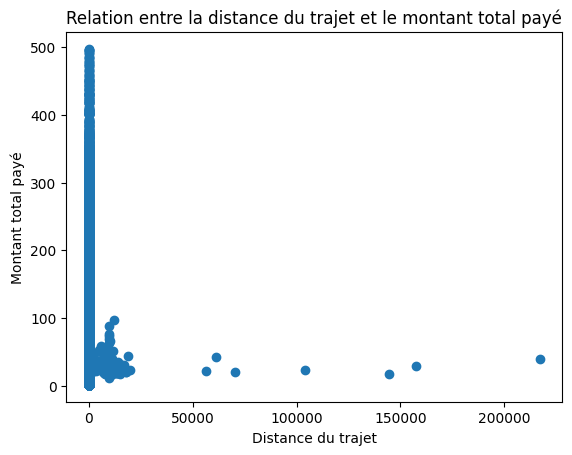

In [ ]:
plt.scatter(df['trip_distance'],df['total_amount'])
plt.xlabel('Distance du trajet')
plt.ylabel('Montant total payé')
plt.title('Relation entre la distance du trajet et le montant total payé')
plt.show()

### variable 'trip_distance'

In [ ]:
df['trip_distance'].mean()

3.907970029776337

In [ ]:
df['trip_distance'].max()

216986.96

In [ ]:
df[df['trip_distance']>1000].value_counts()

tpep_pickup_datetime  passenger_count  trip_distance  PULocationID  DOLocationID  payment_type  total_amount  mois  jour  annee  heure  minute  joursemaine  duree_minute
2023-03-01 04:42:00   1.0              9385.19        151           234           0             25.61         3     1     2023   4      42      2            17.000000       1
2023-03-18 17:32:00   1.0              8731.16        142           140           0             21.38         3     18    2023   17     32      5            17.000000       1
2023-03-23 07:32:00   1.0              12858.71       24            137           0             34.80         3     23    2023   7      32      3            26.000000       1
2023-03-22 05:05:00   1.0              6378.99        236           138           0             53.09         3     22    2023   5      5       2            14.000000       1
2023-03-21 19:38:54   1.0              9683.28        132           217           1             73.55         3     21    2023   1

In [ ]:
(df['trip_distance']>250).value_counts()

False    3373053
True          95
Name: trip_distance, dtype: int64

In [ ]:
df.drop(df[(df['trip_distance']>250)].index, inplace=True)

In [ ]:
df.shape

(3373053, 14)

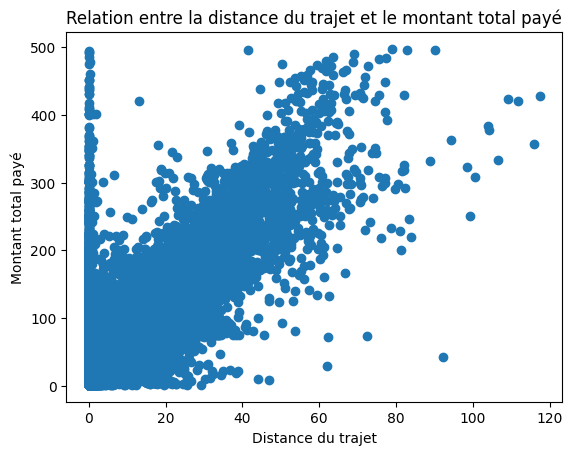

In [ ]:
plt.scatter(df['trip_distance'],df['total_amount'])
plt.xlabel('Distance du trajet')
plt.ylabel('Montant total payé')
plt.title('Relation entre la distance du trajet et le montant total payé')
plt.show()

# statistiques descriptives

In [ ]:
df.dtypes

tpep_pickup_datetime    datetime64[ns]
passenger_count                float64
trip_distance                  float64
PULocationID                     int32
DOLocationID                     int32
payment_type                     int64
total_amount                   float64
mois                             int64
jour                             int64
annee                            int64
heure                            int64
minute                           int64
joursemaine                      int64
duree_minute                   float64
dtype: object

In [ ]:
df['passenger_count'].value_counts()

1.0    2589762
2.0     474552
3.0     116709
0.0      58291
4.0      58284
5.0      46340
6.0      29094
8.0         11
7.0          7
9.0          3
Name: passenger_count, dtype: int64

<Axes: >

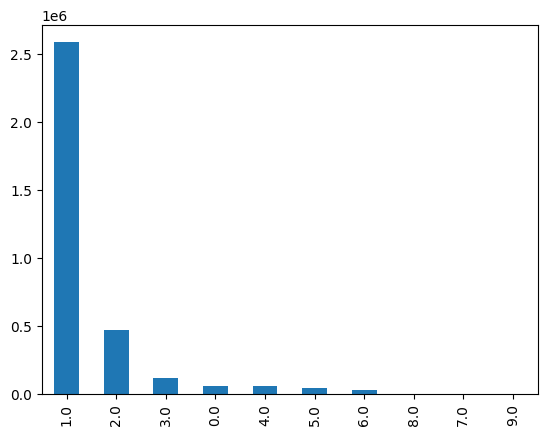

In [ ]:
df['passenger_count'].value_counts().plot.bar()

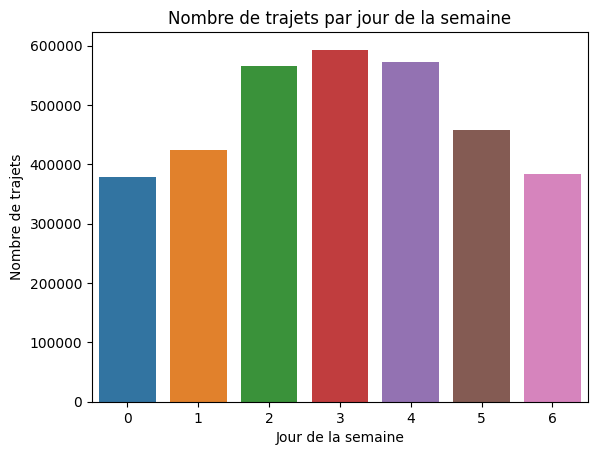

In [ ]:
sns.countplot(x='joursemaine', data=df)
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de trajets')
plt.title('Nombre de trajets par jour de la semaine')
plt.xticks(rotation=0)
plt.show()

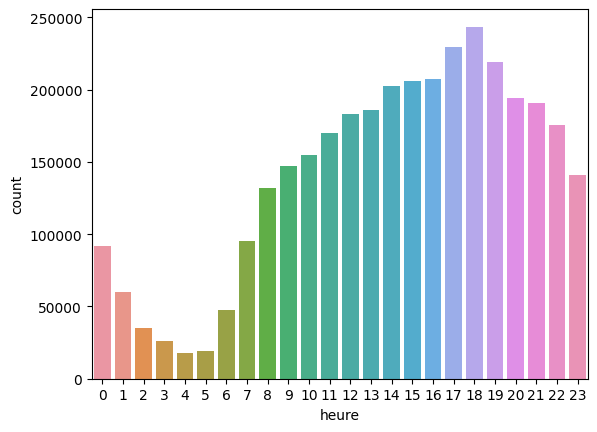

In [ ]:
sns.countplot(x='heure', data=df)
plt.show()

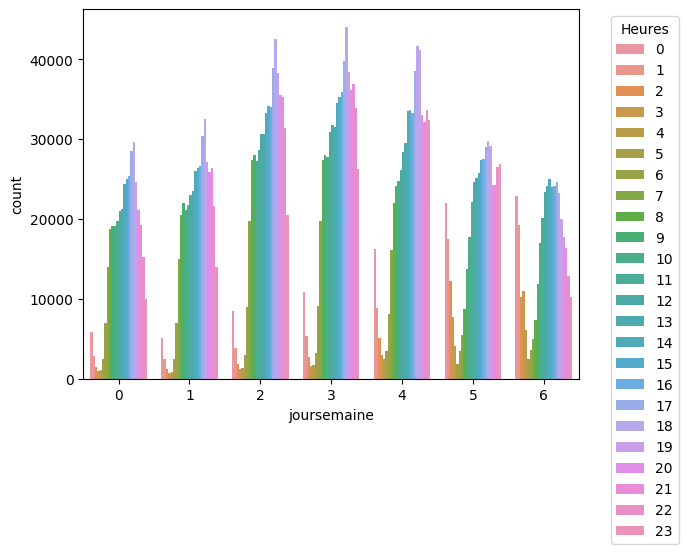

In [ ]:
sns.countplot(x='joursemaine',hue='heure', data=df)
#plt.legend().remove()
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left',title='Heures')
plt.show()

In [ ]:
df['total_amount'].mean()

28.26321466635715

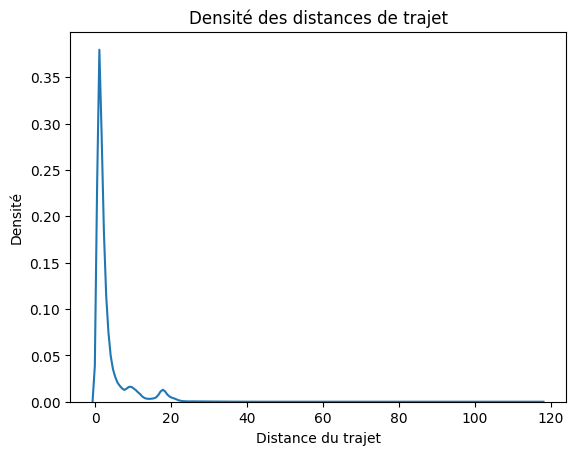

In [ ]:
sns.kdeplot(df['trip_distance'])
plt.xlabel('Distance du trajet')
plt.ylabel('Densité')
plt.title('Densité des distances de trajet')
plt.show()

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3373053 entries, 0 to 3403765
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[ns]
 1   passenger_count       float64       
 2   trip_distance         float64       
 3   PULocationID          int32         
 4   DOLocationID          int32         
 5   payment_type          int64         
 6   total_amount          float64       
 7   mois                  int64         
 8   jour                  int64         
 9   annee                 int64         
 10  heure                 int64         
 11  minute                int64         
 12  joursemaine           int64         
 13  duree_minute          float64       
dtypes: datetime64[ns](1), float64(4), int32(2), int64(7)
memory usage: 360.3 MB


# création des 2 jeux de données : entraînement et test

In [ ]:
x=df.drop('total_amount', axis=1)

In [ ]:
y=df['total_amount']

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

# modélisation

## Régression linéaire

In [ ]:
#lr = LinearRegression()
#lr.fit(x_train,y_train)

In [ ]:
#print(lr.coef_)
#print(lr.intercept_)

#predictions = lr.predict(x_test)
#print('MSE: ', metrics.mean_squared_error(y_test,predictions))

In [ ]:
#lasso = Lasso()
#lasso.fit(x_train,y_train)

#print(lasso.coef_)
#print(lasso.intercept_)

#predictions = lasso.predict(x_test)

#print('MSE: ',metrics.mean_squared_error(y_test,predictions))


In [ ]:
df['DATE'] = pd.to_datetime(df['tpep_pickup_datetime'], format="%d/%m/%Y")
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], format="%d/%m/%Y")
df_merged = pd.merge(df, df_weather, on='DATE', how='left')

In [ ]:
df.shape

(3373053, 15)

In [ ]:
df_merged

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,...,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,SUNSET,SUNRISE,TEMPERATURE_NIGHT_C
0,2023-03-01 00:06:43,1.0,0.00,238,42,2,11.10,3,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-01 00:08:25,2.0,12.40,138,231,1,76.49,3,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-01 00:15:04,0.0,3.30,140,186,1,28.05,3,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-01 00:49:37,1.0,2.90,140,43,1,24.70,3,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-03-01 00:08:04,1.0,1.23,79,137,1,14.64,3,1,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3373048,2023-03-31 23:24:25,1.0,3.16,163,75,0,20.36,3,31,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3373049,2023-03-31 23:24:50,1.0,6.89,125,198,0,53.90,3,31,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3373050,2023-03-31 23:26:31,1.0,4.01,50,224,0,28.02,3,31,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3373051,2023-03-31 23:07:51,1.0,1.31,113,158,0,16.01,3,31,2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## KNN

In [ ]:
# Séparation des caractéristiques (X) et de la variable cible (y)
X = df[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute']]  # Caractéristiques
y = df['total_amount']  # Variable cible

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle KNN
knn = KNeighborsRegressor(n_neighbors=11)  # Spécifiez le nombre de voisins (K) à utiliser

# Entraînement du modèle
knn.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = knn.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)


KeyboardInterrupt: ignored

In [ ]:
df

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,duree_minute
0,1.0,0.00,238,42,2,11.10,3,1,2023,0,6,2,10.000000
1,2.0,12.40,138,231,1,76.49,3,1,2023,0,8,2,31.083333
2,0.0,3.30,140,186,1,28.05,3,1,2023,0,15,2,14.366667
3,1.0,2.90,140,43,1,24.70,3,1,2023,0,49,2,11.466667
4,1.0,1.23,79,137,1,14.64,3,1,2023,0,8,2,3.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403761,1.0,3.16,163,75,0,20.36,3,31,2023,23,24,4,16.483333
3403762,1.0,6.89,125,198,0,53.90,3,31,2023,23,24,4,39.366667
3403763,1.0,4.01,50,224,0,28.02,3,31,2023,23,26,4,23.133333
3403764,1.0,1.31,113,158,0,16.01,3,31,2023,23,7,4,8.083333


## Réseaux de neurones

In [ ]:
# Séparation des caractéristiques (X) et de la variable cible (y)
X = df[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute']]  # Caractéristiques
y = df['total_amount']  # Variable cible

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilation du modèle
model.compile(loss='mean_squared_error', optimizer='adam')

# Entraînement du modèle
model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

# Prédiction sur les données de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)


Epoch 1/70
84327/84327 [==============================] - 119s 1ms/step - loss: 66.1624
Epoch 2/70
84327/84327 [==============================] - 117s 1ms/step - loss: 63.1081
Epoch 3/70
84327/84327 [==============================] - 114s 1ms/step - loss: 58.9253
Epoch 4/70
84327/84327 [==============================] - 113s 1ms/step - loss: 55.1168
Epoch 5/70
84327/84327 [==============================] - 115s 1ms/step - loss: 53.3445
Epoch 6/70
84327/84327 [==============================] - 112s 1ms/step - loss: 52.9603
Epoch 7/70
84327/84327 [==============================] - 113s 1ms/step - loss: 56.1232
Epoch 8/70
84327/84327 [==============================] - 119s 1ms/step - loss: 50.0744
Epoch 9/70
84327/84327 [==============================] - 120s 1ms/step - loss: 48.7209
Epoch 10/70
84327/84327 [==============================] - 113s 1ms/step - loss: 47.6373
Epoch 11/70
84327/84327 [==============================] - 115s 1ms/step - loss: 47.0553
Epoch 12/70
84327/84327 [=====

## Support Vector Machine

In [ ]:
# Sélectionnez vos fonctionnalités (variables indépendantes) et votre variable cible (variable dépendante)
features = df[['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID']]
target = df['total_amount']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

In [ ]:
# Appliquez une mise à l'échelle sur les fonctionnalités
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créez et entraînez le modèle SVM
svm_model = SVR(kernel='linear')

In [ ]:
svm_model.fit(X_train_scaled, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = svm_model.predict(X_test_scaled)

# Évaluez les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [ ]:
X_train.isnull().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
dtype: int64